# SARIMAX
- The (extended) ARIMA family of methods is too big to be properly explained in this course.
    - At NMBU, the course DAT320 goes deeper and explains the data generating processes.
    - An online book with videos: [Forecasting: Principles and Practice](https://otexts.com/fpp3/).
- We therefore skip (almost) directly to the regression models (inspired by [phosgene89's GitHub page](https://phosgene89.github.io/sarima.html), except for their errors) and their usage.
- But first we introduce a dataset and the concepts of stationarity and autocorrelation.

__Stationarity:__
- The distribution of the time series is independent of which part of the time series you look at.
    - Trends, seasonality (cycles of fixed width) and changes in variance lead to non-stationarity.
    - Differencing (first or second order discrete derivatives) can help.
        - Seasonal differencing means the difference is not between neighbours but higher lags.
- If the data is not stationary, pre-processing or modelling of the specific deviations from stationarity is needed.

## Wholesale price index (WPI) data
- We will illustrate some concepts and models using the WPI data.

In [1]:
# Imports
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO

# Load Wholesale price index (WPI) data
wpi1 = requests.get('https://www.stata-press.com/data/r12/wpi1.dta').content
data = pd.read_stata(BytesIO(wpi1))
data.index = data.t
data['ln_wpi'] = np.log(data['wpi'])
data['D.ln_wpi'] = data['ln_wpi'].diff()
# Set the frequency to Quarterly Start, year ending October
data.index.freq="QS-OCT"
data.head()

,wpi,t,ln_wpi,D.ln_wpi
t,,,,
1960-01-01,30.700001,1960-01-01,3.424263,NaN
1960-04-01,30.799999,1960-04-01,3.427515,0.003252
1960-07-01,30.700001,1960-07-01,3.424263,-0.003252
1960-10-01,30.700001,1960-10-01,3.424263,0.000000
1961-01-01,30.799999,1961-01-01,3.427515,0.003252


## Autocorrelation
- [Autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) is the correlation between a stationary timeseries and a lagged version of itself.
    - This is a measure of the time dependence in the series, i.e., lack of independence.
    - Can be used to indicate the appropriate lag in moving average (MA) models.
- [Partial autocorrelation](https://en.wikipedia.org/wiki/Partial_autocorrelation_function) is the autocorrelation when controlling for (regressed on) all intermediate time lags.
    - Can be used to indicate the appropriate lag in autogregressive (AR) models.

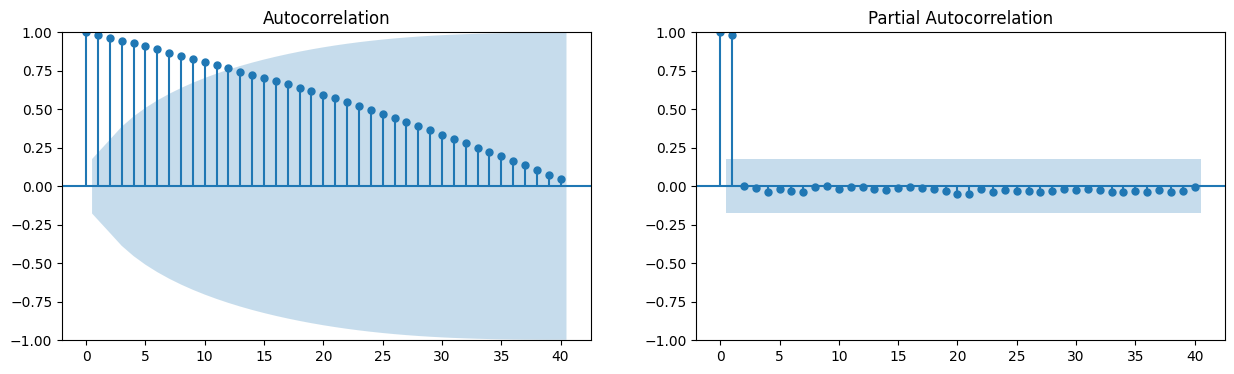

In [2]:
# Autocorrelation and partial autocorrelation plots (raw data)
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = sm.graphics.tsa.plot_acf(data.iloc[1:]['wpi'], lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(data.iloc[1:]['wpi'], lags=40, ax=axes[1])

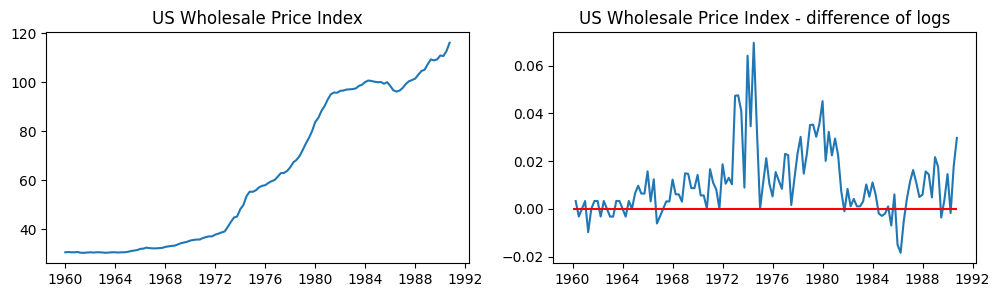

In [3]:
# Graph data
fig, axes = plt.subplots(1, 2, figsize=(12,3))

# Levels
axes[0].plot(data.index._mpl_repr(), data['wpi'], '-')
axes[0].set(title='US Wholesale Price Index')

# Log difference (attempting to improve stationarity)
axes[1].plot(data.index._mpl_repr(), data['D.ln_wpi'], '-')
axes[1].hlines(0, data.index[0], data.index[-1], 'r')
axes[1].set(title='US Wholesale Price Index - difference of logs');

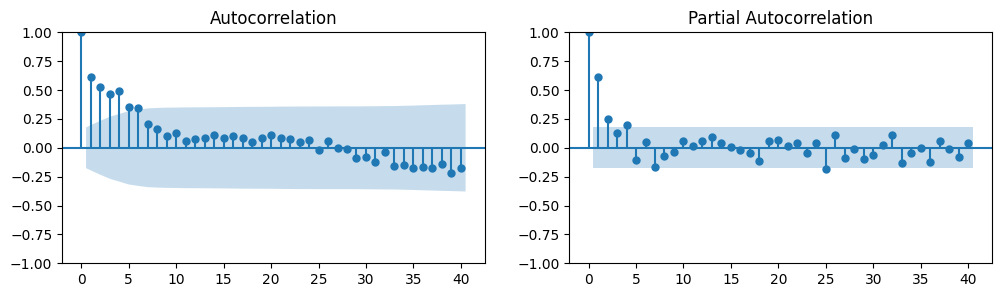

In [4]:
# Autocorrelation and partial autocorrelation plots 
# after applying the logarithm and differencing
fig, axes = plt.subplots(1, 2, figsize=(12,3))
fig = sm.graphics.tsa.plot_acf(data.iloc[1:]['D.ln_wpi'], lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(data.iloc[1:]['D.ln_wpi'], lags=40, ax=axes[1])

## Autoregressive models in Python
- Using the [_statsmodels_](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) package, the most complex model is the starting point.
- Setting the various parameters of $SARIMAX(p, d, q)(P, D, Q, s)$, we can obtain any of the below mentioned models.
    - SARIMAX(endog, exog=None, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0), trend=None, ...)
- For integer values of $p/d/q/P/D/Q$, all lags up to the integer are included. For more fine-grained control, lists can be applied, e.g., [1,0,1] includes lags 1 and 3, but not 2.
- There are also various other parameters, e.g., a trend (none, constant, linear, quadratic, polynomial).

## Lag operator
- Back-shift $n$ time points, i.e., extracts the measurement $n$ time points before $t$.
$$L^{n} y_{t} = y_{t-n}$$  
- Combined with a vector of parameters $\Psi$, we define a polynomial function
$$\Psi(L)^n y_t = y_t + \psi_1 y_{t-1} + \psi_2 y_{t-2} + ... + \psi_n y_{t-n}$$
- This will enable compact notation of the SARIMAX models, exchanging sums with the polynomial function.

## AR - autoregressive models
- For a (single variable) timeseries given by $\{ y_{t} \}$, we can specify the $AR(p)$ model as:
  
$$ y_{t} = \theta_0 + \sum\limits_{i=1}^p \theta_{i} y_{t-i} + \epsilon_{t}$$
  
- i.e., the current time is a function of $p$ previous time points and a constant. 
- Here, $\theta_0$ is a constant, $\theta_{i}$ is the coefficient for the $p$-th time lag and $\epsilon_{t}$ is the error. 
- This can be thought of as stacking subsets of a time series using a moving window and performing ordinary least squares on the resulting matrix/dataframe. 
    - In practice, the fitting is performed using maximum likelihood, so performing ordinary regression will not give exactly the same results.
- Using the lag operator, $L^{n} y_{t} = y_{t-n}$, we can redefine the above equation in the form of a polynomial function, $\Theta(L)^{p}$ (signs of coefficients will change) as:
  
$$ \Theta(L)^{p} y_{t} = \theta_0 + \epsilon_{t}.$$

In [5]:
# Fit an AR(1) model (badly specified due to non-stationarity)
mod = sm.tsa.statespace.SARIMAX(data['wpi'], trend='c', order=(1,0,0)) # trend='c' adds a constant
res = mod.fit(disp=False)
print(res.summary()) # AIC gives us a measure of fit for comparison

                               SARIMAX Results                                
Dep. Variable:                    wpi   No. Observations:                  124
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -201.927
Date:                Mon, 08 Sep 2025   AIC                            409.855
Time:                        09:22:10   BIC                            418.316
Sample:                    01-01-1960   HQIC                           413.292
                         - 10-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0293      0.343      0.086      0.932      -0.643       0.701
ar.L1          0.9996      0.005    213.302      0.000       0.990       1.009
sigma2         1.4355      0.143     10.008      0.0

/Users/kristian/miniforge3/envs/ind320_25/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


## MA - moving average models
- MA models are functions of previous errors, rather than previous measurements. 
- We can define an $MA(q)$ model as:
  
$$ y_{t} = \phi_0 + \sum\limits_{i=1}^q \phi_{i} \epsilon_{t-i} + \epsilon_{t}$$
$$ = \phi_0 + \Phi(L)^{q} \epsilon_{t}.$$
  
- Here, $q$ is the number of time lags and $\Phi(L)^{q}$ is defined as $\Theta$ above, but using the error terms and $\epsilon_{t}$ is with respect to the current model.

In [6]:
# Fit an MA(1) model (disregarding the obvious autocorrelation)
mod = sm.tsa.statespace.SARIMAX(data['wpi'], trend='c', order=(0,0,1))
res = mod.fit(disp=False)
print(res.summary()) # AIC gives us a measure of fit for comparison

                               SARIMAX Results                                
Dep. Variable:                    wpi   No. Observations:                  124
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -516.522
Date:                Mon, 08 Sep 2025   AIC                           1039.044
Time:                        09:22:10   BIC                           1047.505
Sample:                    01-01-1960   HQIC                          1042.481
                         - 10-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     62.8671      3.033     20.727      0.000      56.922      68.812
ma.L1          0.9994      0.578      1.728      0.084      -0.134       2.133
sigma2       233.8562    132.640      1.763      0.0

/Users/kristian/miniforge3/envs/ind320_25/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


## ARMA - autoregressive moving average models
- When we take the sum of $AR(p)$ and $MA(q)$ models of the same time series, we get $ARMA(p,q)$ models:
  
$$ y_{t} = \theta_0 + \sum\limits_{i=1}^p \theta_{i} y_{t-i} + \sum\limits_{i=1}^q \phi_{i} \epsilon_{t-i} + \epsilon_{t}$$

- which can be reformulated to:

$$ \Theta(L)^{p} y_{t} = \theta_0 + \Phi(L)^{q} \epsilon_{t}$$
  
- Again, $\epsilon_{t}$ is with respect to the current model, but shares name with the previous models.
- This model is learning both from seeing previous samples and from how well these were predicted at previous time steps, thus it can tackle changes in the average.

In [7]:
# Fit an ARMA(1,1) model (badly specified due to non-stationarity)
mod = sm.tsa.statespace.SARIMAX(data['wpi'], trend='c', order=(1,0,1))
res = mod.fit(disp=False)
print(res.summary()) # AIC gives us a measure of fit for comparison

                               SARIMAX Results                                
Dep. Variable:                    wpi   No. Observations:                  124
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -172.610
Date:                Mon, 08 Sep 2025   AIC                            353.221
Time:                        09:22:10   BIC                            364.502
Sample:                    01-01-1960   HQIC                           357.804
                         - 10-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0438      0.427      0.103      0.918      -0.794       0.882
ar.L1          0.9994      0.006    172.091      0.000       0.988       1.011
ma.L1          0.5628      0.072      7.848      0.0

/Users/kristian/miniforge3/envs/ind320_25/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


## ARIMA - autoregressive integrated moving average models
- To help compensate for lack of stationarity, we add an integration operator, $\Delta^{d}$, defined as:
  
$$y_{t}^{[d]} = \Delta^{d} y_{t} = y_{t}^{[d-1]} - y_{t-1}^{[d-1]}.$$
  
- Here, $y_{t}^{[0]} = y_{t}$ and the degree of differensing is $d$.
- For instance with $d=2$:

$$y_{t}^{[2]} = \Delta^{2} y_{t} = y_{t}^{[1]} - y_{t-1}^{[1]} $$
$$= y_{t}^{[0]} - y_{t-1}^{[0]} - y_{t-1}^{[0]} + y_{t-2}^{[0]} = y_{t} - 2 y_{t-1} + y_{t-2}$$

- An $ARMA(p, q)$ model where $y_{t}$ is exchanged with $y_{t}^{[d]}$ would look like this:
  
$$ \Theta(L)^{p} y_{t}^{[d]} = \Phi(L)^{q} \epsilon_{t}$$

- The constant is often omitted and assumed absorbed by the integration. Only the time series is integrated, not the errors.  
- Reformulating this using the integration operator, we get an $ARIMA(p,d,q)$ model:
  
$$ \Theta(L)^{p} \Delta^{d} y_{t} = \Phi(L)^{q} \epsilon_{t}$$
  
- This model has the properties of the ARMA model, but in addition does the differensing for us for stationarity.
- The terms can be reorganised to get predictions on the original scale instead of predicting difference values.

In [8]:
# Fit an ARIMA(1,1,1) model
mod = sm.tsa.statespace.SARIMAX(data['wpi'], trend=None, order=(1,1,1))
res = mod.fit(disp=False)
print(res.summary()) # AIC gives us a measure of fit for comparison

                               SARIMAX Results                                
Dep. Variable:                    wpi   No. Observations:                  124
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -137.247
Date:                Mon, 08 Sep 2025   AIC                            280.494
Time:                        09:22:10   BIC                            288.930
Sample:                    01-01-1960   HQIC                           283.920
                         - 10-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9412      0.030     31.695      0.000       0.883       0.999
ma.L1         -0.4656      0.088     -5.314      0.000      -0.637      -0.294
sigma2         0.5398      0.054     10.071      0.0

In [9]:
# Since the data are quarterly, we can add a seasonal component by including a fourth time lag to moving average
# Fit an ARIMA(1,1,[1,0,0,1]) model
mod = sm.tsa.statespace.SARIMAX(data['wpi'], trend=None, order=(1,1,[1,0,0,1]))
res = mod.fit(disp=False)
print(res.summary()) # AIC gives us a measure of fit for comparison
# What about a linear trend? (trend='t')

                                 SARIMAX Results                                 
Dep. Variable:                       wpi   No. Observations:                  124
Model:             SARIMAX(1, 1, [1, 4])   Log Likelihood                -137.202
Date:                   Mon, 08 Sep 2025   AIC                            282.404
Time:                           09:22:10   BIC                            293.653
Sample:                       01-01-1960   HQIC                           286.973
                            - 10-01-1990                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9313      0.041     22.884      0.000       0.852       1.011
ma.L1         -0.4540      0.093     -4.884      0.000      -0.636      -0.272
ma.L4          0.0433      0

## SARIMA - seasonal autoregressive integrated moving average models
- SARIMA shares some resemblance with the STL decomposition introduced previously.
- For seasons of length $s$, the seasonal part is obtained by applying an ARIMA model with lags, $P$ and $Q$, and integration time, $D$, that are multiples of $s$, i.e., if $P=2$, the included time points would be $t-1s$ and $t-2s$.
  
$$ \theta(L^{s})^{P} \Delta_{s}^{D} y_{t} = \phi(L^{s})^{Q} \epsilon_{t} $$

- After the seasonal part has been removed, another $ARIMA(p, d, q)$ applied to $\Delta_{s}^{D} y_{t}$ which is equivalent to multiplying the two models together.
- The $SARIMA(p, d, q)(P, D, Q, s)$ model then becomes:
  
$$ \Theta(L)^{p} \theta(L^{s})^{P} \Delta^{d} \Delta_{s}^{D} y_{t} = \Phi(L)^{q} \phi(L^{s})^{Q} \epsilon_{t}$$
  
- This model has the ability to combine experience from previous timepoints with seasonal trends. 
    - Or if one sets the ARIMA parameters $p=0$, $d=0$, $q=0$, one can have a pure seasonal model.

In [10]:
# Using SARIMA for seasonality instead of the fourth time lag to moving average.
# Fit a SARIMA(1,1,1)(1,1,1,4) model
mod = sm.tsa.statespace.SARIMAX(data['wpi'], trend=None, order=(1,1,1), seasonal_order=(1,1,1,4))
res = mod.fit(disp=False)
print(res.summary()) # AIC gives us a measure of fit for comparison (no improvement here)

                                     SARIMAX Results                                     
Dep. Variable:                               wpi   No. Observations:                  124
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood                -135.889
Date:                           Mon, 08 Sep 2025   AIC                            281.778
Time:                                   09:22:11   BIC                            295.674
Sample:                               01-01-1960   HQIC                           287.421
                                    - 10-01-1990                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8767      0.060     14.588      0.000       0.759       0.994
ma.L1         -0.3819      0.111     -3.453

## Exogenous variables
- As we showed in the previous chapter, it is possible to make a model purely on other variables measured at the same time, $t$.
- Including these variables into ARIMA and SARIMA, we get the ARIMAX and SARIMAX models.
- In practice, we paste on an extra coefficient vector, $\beta$, and variables, $X_{t}$, to the models, here noted as sums of products $\beta_{i} x^{i}_{t}$: 
- $ARIMAX(p, d, q)$:
  
$$\Theta(L)^{p} \Delta^{d} y_{t} = \Phi(L)^{q} \epsilon_{t} + \sum_{i=1}^{n} \beta_{i} x^{i}_{t}$$
  
- $SARIMAX(p, d, q)(P, D, Q, s)$:
  
$$\Theta(L)^{p} \theta(L^{s})^{P} \Delta^{d} \Delta_{s}^{D} y_{t} = \Phi(L)^{q} \phi(L^{s})^{Q} \epsilon_{t} + \sum_{i=1}^{n} \beta_{i} x^{i}_{t}$$
  
- The final model, thus includes autogression and moving averages, can perform differences, deals with seasonality and can leverage external variables from the same timepoint as the predictions.

In [11]:
# Read the FinalData sheet of the OilExchange.xlsx file using Pandas again
import pandas as pd
OilExchange = pd.read_excel('../../data/OilExchange.xlsx', sheet_name='FinalData')
OilExchange.index = OilExchange.Date
OilExchange.index.freq = "MS" # Set the frequency to Month Start
OilExchange.head()

/Users/kristian/miniforge3/envs/ind320_25/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Date,PerEURO,PerUSD,KeyIntRate,LoanIntRate,EuroIntRate,CPI,OilSpotPrice,ImpOldShip,ImpNewShip,...,ExpExShipOilPlat,TrBal,TrBalExShipOilPlat,TrBalMland,ly.var,l2y.var,l.CPI,ExcChange,Testrain,season
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,2000-01-01,8.1215,8.0129,5.500000,7.500000,3.04,104.1,25.855741,114,915,...,38619,18575,19238,-3257,8.0968,8.1907,103.6,Increase,True,winter
2000-02-01,2000-02-01,8.0991,8.2361,5.500000,7.500000,3.28,104.6,27.317905,527,359,...,38730,14217,17200,-4529,8.1215,8.0968,104.1,Decrease,True,winter
2000-03-01,2000-03-01,8.1110,8.4111,5.500000,7.500000,3.51,104.7,26.509183,1385,929,...,42642,13697,18380,-5562,8.0991,8.1215,104.6,Increase,True,Spring
2000-04-01,2000-04-01,8.1538,8.6081,5.632353,7.632353,3.69,105.1,21.558821,450,2194,...,36860,13142,15499,-5147,8.1110,8.0991,104.7,Increase,True,Spring
2000-05-01,2000-05-01,8.2015,9.0471,5.750000,7.750000,3.92,105.1,25.147242,239,608,...,42932,17733,18505,-5732,8.1538,8.1110,105.1,Increase,True,Spring


In [12]:
# Fit a SARIMAX(1,1,1)(1,1,1,12) model with exogenous variables (closing our eyes, as we know little about the data)
mod = sm.tsa.statespace.SARIMAX(OilExchange['PerEURO'], exog=OilExchange.loc[:, OilExchange.columns[3:-6]], \
                                trend='c', order=(1,1,1), seasonal_order=(1,1,1,12))
res = mod.fit(disp=False)
print(res.summary()) # AIC gives us a measure of fit for comparison (no improvement here)

                                     SARIMAX Results                                      
Dep. Variable:                            PerEURO   No. Observations:                  179
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 103.848
Date:                            Mon, 08 Sep 2025   AIC                           -157.695
Time:                                    09:22:12   BIC                            -79.896
Sample:                                01-01-2000   HQIC                          -126.116
                                     - 11-01-2014                                         
Covariance Type:                              opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
intercept              0.0011      0.018      0.061      0.951      -0.034       0.037
KeyIntRate 

/Users/kristian/miniforge3/envs/ind320_25/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Exercise
- Play with the OilExchange data.
- See if you can improve the fit of the model by adjusting lags and removing the least significant terms in the model.

## SARIMAX prediction
- One-step-ahead prediction uses the estimated parameters and samples within the lags of the model to predict the next time point.
    - This means that the predictions will stay relatively close to the true values, never predicting more than one step away from the truth.
- Dynamic prediction predicts one step as above, then uses predicted values as input instead of true values.
    - This means the predictions can deviate from the truth over time.

In [13]:
# Refit the model on the training set (up to 2013-01-01) to estimate the parameters
mod = sm.tsa.statespace.SARIMAX(OilExchange['PerEURO'].loc[:'2013-01-01'], \
                                OilExchange.loc[:, OilExchange.columns[3:-4]].loc[:'2013-01-01'], \
    trend='c', order=(1,1,1), seasonal_order=(1,1,1,12))
res = mod.fit(disp=False)

/Users/kristian/miniforge3/envs/ind320_25/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/kristian/miniforge3/envs/ind320_25/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


/Users/kristian/miniforge3/envs/ind320_25/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
# Get predictions for the whole dataset
mod = sm.tsa.statespace.SARIMAX(OilExchange['PerEURO'], OilExchange.loc[:, OilExchange.columns[3:-4]], \
    trend='c', order=(1,1,1), seasonal_order=(1,1,1,12))

res = mod.filter(res.params) # One-step-ahead predictions using parameters from previous fit

In [15]:
# In-sample one-step-ahead prediction wrapper function
predict = res.get_prediction()
predict_ci = predict.conf_int()

In [16]:
# Dynamic predictions starting from 2013-01-01
predict_dy = res.get_prediction(dynamic='2013-01-01')
predict_dy_ci = predict_dy.conf_int()

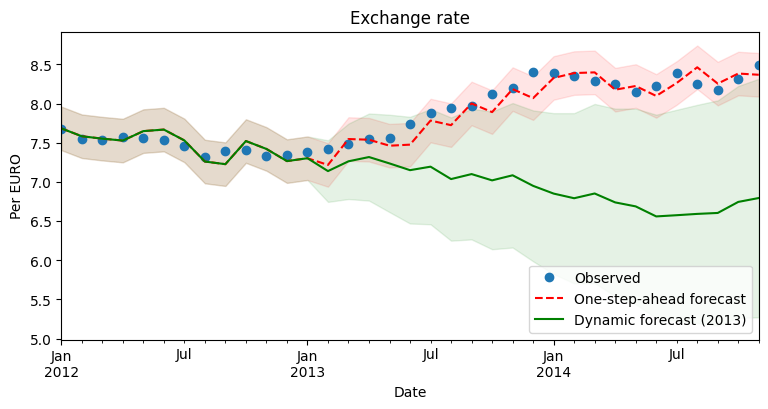

In [17]:
# Compare the one-step-ahead predictions to the dynamic predictions
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Exchange rate', xlabel='Date', ylabel='Per EURO')

# Plot data points
OilExchange.loc['2012-01-01':, 'PerEURO'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc['2012-01-01':].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc['2012-01-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
predict_dy.predicted_mean.loc['2012-01-01':].plot(ax=ax, style='g', label='Dynamic forecast (2013)')
ci = predict_dy_ci.loc['2012-01-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')

## Questercise
- Does the model made in the previous exercise improve the predictions as visualized above?

```{seealso} 
:class: tip

## Resources
- [Book and video lectures on Forecasting: Principles and Practice](https://otexts.com/fpp3/)
- [Wikipedia: Autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation)
- [Wikipedia: Partial autocorrelation](https://en.wikipedia.org/wiki/Partial_autocorrelation_function)
- [statsmodels' SARIMAX documentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)
- [statsmodels' SARIMAX example](https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_stata.html)
```